# VR - Motion recognition with simple gestures

## Libraries
* Numpy
* Pandas
* Matplotlib
* PyTorch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.onnx

from xgboost import XGBClassifier

## Importing scripts

In [2]:
from utils.data import Data
from utils.hardware import Hardware
from utils.model import VRGestureRecognizer

## Loading data

In [3]:
# Define base data directory
base_dir: str = os.path.join(os.getcwd(), 'data')

# Load data
tuple_data: tuple[np.ndarray, np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
data: np.ndarray = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]
print("Classes:", classes)

Classes: ['OUI' 'NON' 'VRAI' 'FAUX']


## Settings and hyperparameters ...

In [4]:
DEVICE = Hardware.device()
BATCH_SIZE = 16
EPOCHS = 100

## Model - Convolutional Neural Network

### Training

  0%|          | 0/100 [00:00<?, ?it/s]

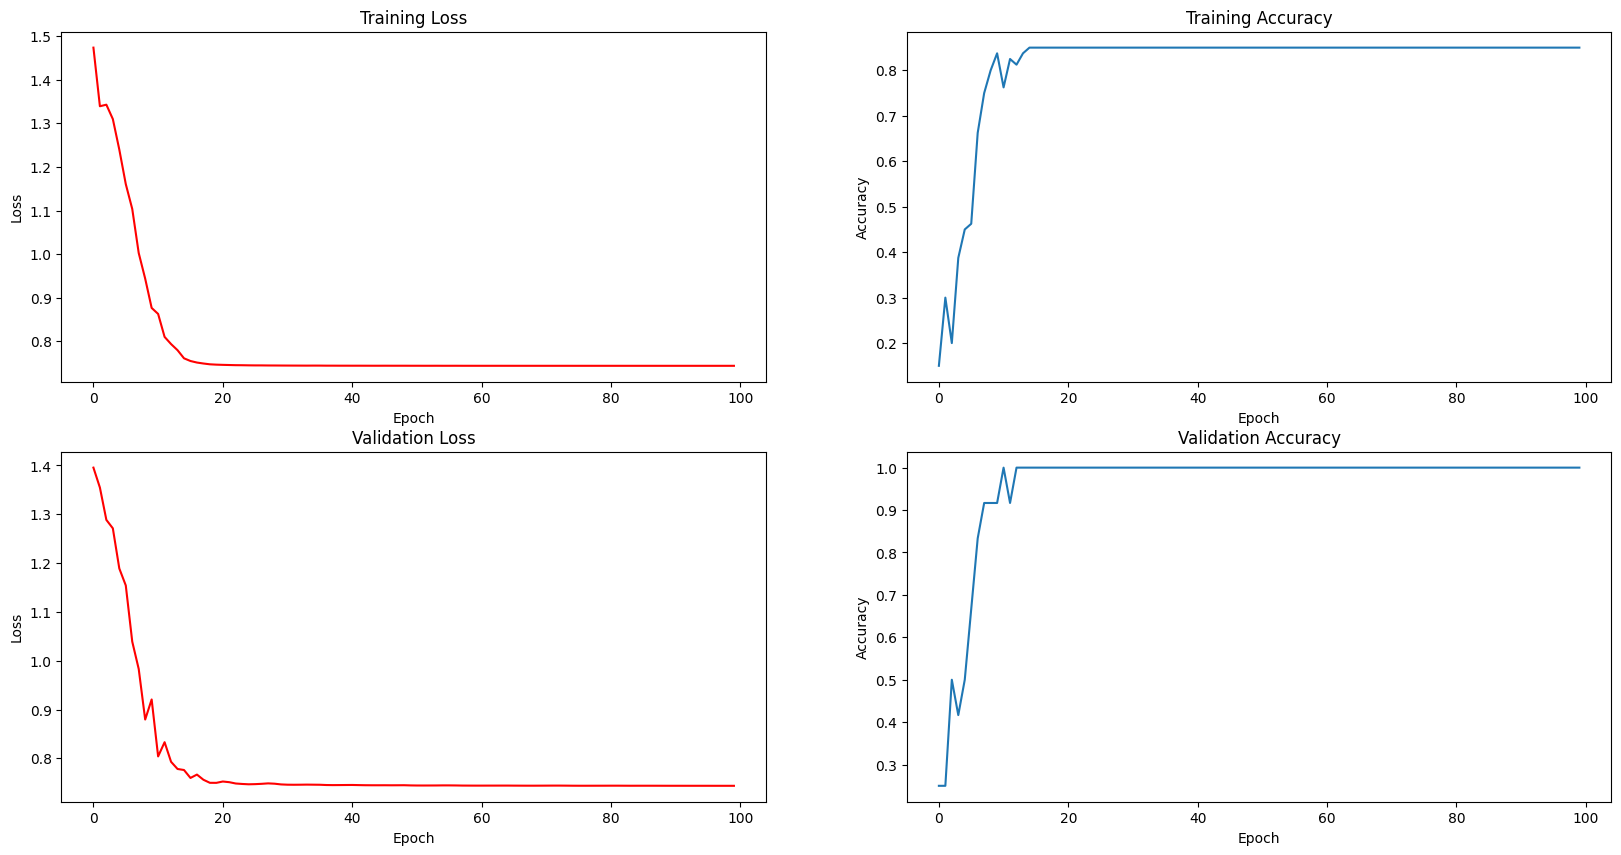

In [5]:
gesture_recognizer = VRGestureRecognizer(hidden_size=128, num_classes=classes.shape[0]).to(Hardware.device(), dtype=torch.float32)
optimizer = torch.optim.Adam(gesture_recognizer.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

gesture_recognizer.compile(optimizer, loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=1e-4)

gesture_recognizer.plot_history()

### Evaluation

In [6]:
test_loss, test_accuracy = gesture_recognizer.to(Hardware.device()).evaluate(X_test, y_test)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy * 100:.2f}%")

Loss: 0.74 | Accuracy: 100.00%


## Results analysis

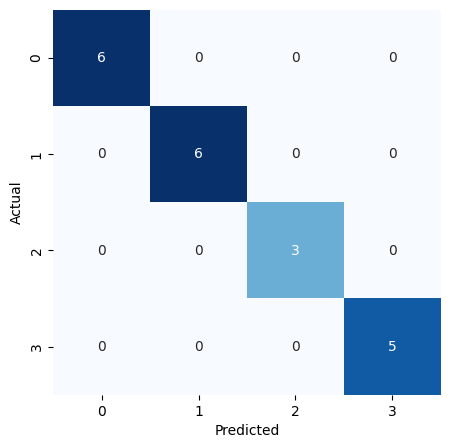

In [7]:
# Confusion matrix
x1 = X_test.copy()
x2 = X_test.copy()
y_pred = gesture_recognizer.to(Hardware.device()).predict(X_test)
cm = confusion_matrix(y_test, y_pred.cpu().numpy().astype(dtype=np.int32))

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [8]:
# Classification report
y_pred = gesture_recognizer.to(Hardware.device()).predict(X_test)
print(classification_report(y_test, y_pred.cpu().numpy().astype(dtype=np.int32), target_names=classes, zero_division=0))

              precision    recall  f1-score   support

         OUI       1.00      1.00      1.00         6
         NON       1.00      1.00      1.00         6
        VRAI       1.00      1.00      1.00         3
        FAUX       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Exporting the model

In [9]:
gesture_recognizer.export_to_onnx(path='gesture_recognizer.onnx')

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## XGBoost

In [ ]:
# TODO: Test XGBoost classifier